# Generate operative dimensions

In [2]:
import os
import numpy as np
import random
from datetime import datetime
from scipy.optimize import minimize

from utils.UtilsIO import UtilsIO
from utils.UtilsPlotting import UtilsPlotting
from utils.UtilsSamplingLocs import UtilsSamplingLocs
from utils.UtilsOpDims import UtilsOpDims

from utils.input_generation.InputGeneratorCtxt import InputGeneratorCtxt
from utils.input_generation.InputGeneratorSWG import InputGeneratorSWG
from utils.run_one_forwardPass import run_one_forwardPass
from utils.make_unit_length import make_unit_length
from utils.get_neg_deltaFF import get_neg_deltaFF

UIO  = UtilsIO()
UPlt = UtilsPlotting()
USL  = UtilsSamplingLocs()
UOD  = UtilsOpDims()

base_dir_data = '../data'

In [3]:
# network settings
net_id = 1
network_type = 'ctxt'  # 'swg': sine wave generator network 'ctxt': context-dependent integration network
dim_type = 'columns'  # 'columns' 'rows'

# noise settings
with_netnoise    = 1  # 0 or 1
with_inputnoise  = 1  # 0 or 1, only for ctxt network

seed_run   = 1001
seed_input = 1000

# SHARED CONSTANTS / PARAMETERS
# load network weights
path_to_weights = os.path.join(base_dir_data, 'pretrained_networks', network_type, network_type+'_weights.h5')
[n_Wru_v, n_Wrr_n, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1] = UIO.load_weights(path_to_weights, net_id)
n_units = np.shape(n_Wrr_n)[0]
n_inputs = np.shape(n_Wru_v)[1]

# network noise
if with_netnoise:
    net_noise   = 'default'
else:
    net_noise   = 0

# generate network inputs to run network
random.seed(seed_input)
if network_type == 'swg':
    n_trials = 51*10  # total, over all 51 frequencies
    [all_freqs, all_freq_ids, inputs, targets, conditionIds] = InputGeneratorSWG().get_sine_wave_generator_inputOutputDataset(n_trials)
    
elif network_type == 'ctxt':
    n_trials = 10  # trials per context and per input coherency
    [coherencies_trial, conditionIds, inputs, targets] = InputGeneratorCtxt().get_ctxt_dep_integrator_inputOutputDataset(n_trials, with_inputnoise)
    
else:
    raise Exception("Network type unknown, please set network_type to 'swg' or 'ctxt'")

## Define sampling locations on condition average trajectory

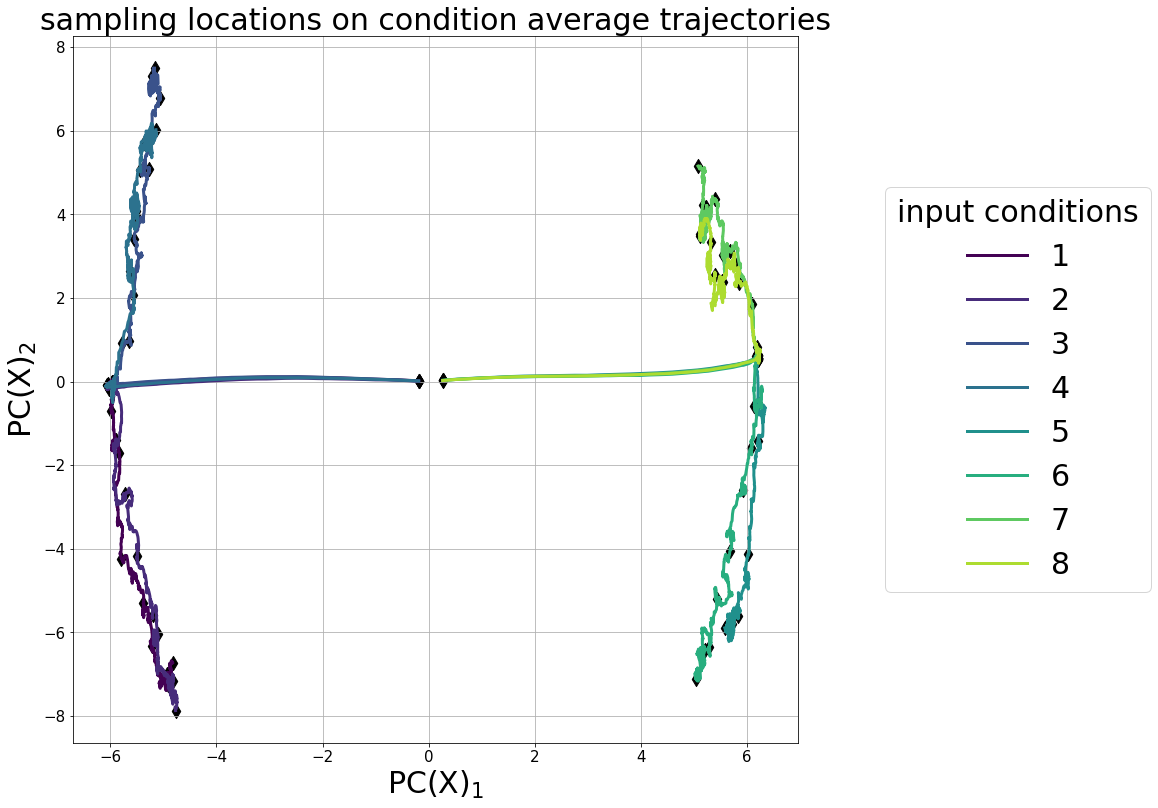

In [4]:
# collect sampling locations for local operative dimensions
# (equally spaced in time, along all condition average trajectories)
sampling_loc_props = USL.get_sampling_location_properties(network_type)

# run network to get condition average trajectories
forwardPass = run_one_forwardPass(n_Wru_v, n_Wrr_n, m_Wzr_n, n_x0_c, n_bx_1, m_bz_1, inputs, conditionIds, seed_run, net_noise)

# extract sampling locations based on defined input conditions and temporal sampling,
# then visualize sampling locations
if network_type == 'swg':
    sampling_locs = USL.get_sampling_locs_on_condAvgTrajs_swg(forwardPass["n_x_t"], sampling_loc_props, all_freq_ids)
    [fig, ax] = UPlt.plot_sampling_locs_on_condAvgTrajs(forwardPass["n_x_t"], sampling_locs, sampling_loc_props, all_freq_ids, [], [], network_type)
elif network_type == 'ctxt':
    sampling_locs = USL.get_sampling_locs_on_condAvgTrajs_ctxt(forwardPass["n_x_t"], sampling_loc_props, conditionIds, coherencies_trial)
    [fig, ax] = UPlt.plot_sampling_locs_on_condAvgTrajs(forwardPass["n_x_t"], sampling_locs, sampling_loc_props, [], conditionIds, coherencies_trial, network_type)  

## Find local operative dimensions at every sampling location

In [5]:
time_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
outputfilename = os.path.join(base_dir_data, 'local_operative_dimensions', 'localOpDims_'+network_type+'_'+dim_type+'_'+time_stamp+'.h5')

thr_fval = 1e-8;
n_dims_to_find  = n_units;
n_sampling_locs = np.size(sampling_loc_props["t_start_pt_per_loc"]);
for loc_nr in range(n_sampling_locs):
    samplingLocParams = {};
    samplingLocParams["local_op_dims"] = np.full([n_dims_to_find, n_units], np.nan)
    samplingLocParams["all_fvals"]     = np.full([n_dims_to_find, 1], np.nan)

    # get sampling location
    start_pt_nr = USL.map_optLocNr_to_startPtNr(loc_nr, sampling_loc_props)
    inpCond_nr  = USL.map_optLocNr_to_inpCondNr(loc_nr, sampling_loc_props, network_type)    
    samplingLocParams["sampling_loc"]  = np.reshape(sampling_locs[inpCond_nr, :, start_pt_nr], [n_units, 1])
    
    # info on sampling location
    samplingLocParams["t_start_point"] = sampling_loc_props["t_start_pt_per_loc"][0,loc_nr]
    if network_type == 'swg':
        samplingLocParams["freq_id"] = sampling_loc_props["freq_idx_per_loc"][0,loc_nr]
        dim_name = UOD.get_name_of_local_operative_dims(network_type=network_type, t_start_point=samplingLocParams["t_start_point"], freq_id=samplingLocParams["freq_id"])

    elif network_type == 'ctxt':
        samplingLocParams["ctxt_id"]  = sampling_loc_props["ctxt_per_loc"][0,loc_nr]
        samplingLocParams["signCoh1"] = sampling_loc_props["signCoh1_per_loc"][0,loc_nr]
        samplingLocParams["signCoh2"] = sampling_loc_props["signCoh2_per_loc"][0,loc_nr]
        dim_name = UOD.get_name_of_local_operative_dims(network_type=network_type, t_start_point=samplingLocParams["t_start_point"], ctxt_id=samplingLocParams["ctxt_id"], 
                                                        signCoh1=samplingLocParams["signCoh1"], signCoh2=samplingLocParams["signCoh2"])
        
    # collect trajs for full-rank network as reference
    samplingLocParams["all_trajs_org"] = np.full([n_units, 2], np.nan)
    inputs_relax = np.zeros([n_inputs, 1, 1])
    if network_type == 'swg':
        conditionIds_relax = np.ones([1,1])
        init_n_x0_c = np.reshape(np.asarray(samplingLocParams["sampling_loc"]), [n_units, 1])
    elif network_type == 'ctxt':
        ctxt_id = int(samplingLocParams["ctxt_id"])
        inputs_relax[1+ctxt_id, :, :] = 0;
        conditionIds_relax = np.reshape(np.asarray([ctxt_id, ctxt_id]), [1,2])
        # init_n_x0_c = np.reshape(np.asarray([samplingLocParams.sampling_loc; samplingLocParams.sampling_loc]), [n_units, 2])
        init_n_x0_c = np.concatenate([samplingLocParams["sampling_loc"], samplingLocParams["sampling_loc"]], axis=1)
    
    net_noise_trajs = 0
    forwardPass_modified = run_one_forwardPass(n_Wru_v, n_Wrr_n, m_Wzr_n, init_n_x0_c, n_bx_1, m_bz_1, inputs_relax, conditionIds_relax, seed_run, net_noise_trajs)
    
    # add first step separately and then all the other steps
    samplingLocParams["all_trajs_org"][:, 0] = np.reshape(forwardPass_modified["n_x0_1"][:, 0], [n_units, ])
    samplingLocParams["all_trajs_org"][:, 1] = np.reshape(forwardPass_modified["n_x_t"], [n_units, ])

    if dim_type == 'columns':
        samplingLocParams["local_op_dims"][0, :] = make_unit_length(np.matmul(n_Wrr_n, np.tanh(samplingLocParams["sampling_loc"]))).T

        dims_to_be_orth = np.zeros([100,0])
        fval = get_neg_deltaFF(samplingLocParams["local_op_dims"][0, :].T, dims_to_be_orth, samplingLocParams, n_Wru_v, n_Wrr_n, m_Wzr_n, n_bx_1, m_bz_1, dim_type, network_type)
        samplingLocParams["all_fvals"] = np.full([n_units, 1], np.nan)
        samplingLocParams["all_fvals"][0, 0] = fval

    elif dim_type == 'rows':
        # start optimization process
        print("loc_nr: "+str(loc_nr+1)+'/'+str(n_sampling_locs))
        for dim_nr in range(n_dims_to_find):
            
            
            if dim_nr == 0:
                op_dims = np.zeros([n_units, 0])
            else:
                op_dims = samplingLocParams["local_op_dims"][0:dim_nr, :].T

            # get random initial conditions
            x0 = make_unit_length(np.random.normal(size=[n_units, 1]))            

            # optimize delta f, to find local operative dimension
            dims_to_be_orth = op_dims
            res = minimize(get_neg_deltaFF, x0, method='CG', tol=1e-6, args=(dims_to_be_orth, samplingLocParams, n_Wru_v, n_Wrr_n, m_Wzr_n, n_bx_1, m_bz_1, dim_type, network_type))

            # postprocess found solution x0 (orth to prev dims, unit length) &
            # ...add new x0 & fval to collection over samples               
            new_opDim = np.reshape(make_unit_length(res.x), [n_units, 1])
            Q, _ = np.linalg.qr(np.concatenate([dims_to_be_orth, new_opDim], 1))
            new_opDim = Q[:, -1]
            new_opDim = np.reshape(make_unit_length(new_opDim), [n_units, 1])

            fval = get_neg_deltaFF(new_opDim, dims_to_be_orth, samplingLocParams, n_Wru_v, n_Wrr_n, m_Wzr_n, n_bx_1, m_bz_1, dim_type, network_type)

            samplingLocParams["local_op_dims"][dim_nr, :] = new_opDim.T
            samplingLocParams["all_fvals"][dim_nr, 0] = fval

            if abs(fval) < thr_fval:
                break

    else:
        raise Exception("dim_type unknown, please set network_type to 'columns' or 'rows'")
    
    # save to hdf5
    hdf5_group_name = dim_name
    UIO.save_to_hdf5(outputfilename, hdf5_group_name, samplingLocParams)
    
print("Done! All local operative dimensions saved to: "+outputfilename)

Done! All local operative dimensions saved to: ../data/local_operative_dimensions/localOpDims_ctxt_columns_20221025_211512.h5
